## Creating Figures
Date: 7/24/2024  
Conda: comad_EAC_figures (in both here and terminal)  
[If trying to get RPCA, then cond: comad (in both here and terminal) -- think this should work for everything in here?

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import biom
import qiime2 as q2
from qiime2 import Artifact, Metadata, Visualization
from qiime2.plugins.diversity.pipelines import alpha
from qiime2.plugins.diversity.visualizers import alpha_rarefaction
from scipy.stats import mannwhitneyu
from qiime2.plugins.emperor.visualizers import biplot
from qiime2.plugins import diversity
from matplotlib.colors import LogNorm
from skbio.stats.distance import permanova

from qiime2.plugins.diversity_lib.methods import bray_curtis
from qiime2.plugins.diversity.methods import pcoa
from qiime2.plugins.diversity.methods import pcoa_biplot
from qiime2.plugins import feature_table

from python_scripts.alpha_beta_diversity import *

In [2]:
key_var='_pese_pangenome_align-RS210_masked_none_scrubbed_p0.25'

### Functions

In [3]:
def call_rare(fn, rare_curve=1000):
    
    #Metadata
    metadata = pd.read_csv('processed_data/metadata/metadata_' + fn + '.tsv', sep='\t').set_index('sample_name', drop = True)
    q2_meta = Metadata(metadata)
    
    #import tables
    df_rs210_genome = pd.read_csv('processed_data/pandas_df/' + fn + key_var + '.tsv' , sep='\t', index_col = 0)
    
    #Convert table to q2 object
    ft_rs210_genome = Artifact.import_data("FeatureTable[Frequency]", df_rs210_genome.T) 
    
    #Calculate alpha rarefaction curves
    ar_rs210_genome = alpha_rare_curve(ft_rs210_genome, rare_curve, metadata)
    
    #Save objects
    ar_rs210_genome.visualization.save('processed_data/alpha_rarefaction/' + fn + key_var + '.qzv')
    
    return(ar_rs210_genome)

In [4]:
def table_prep_custom(table, fn, rarefaction=None, import_prior=None, save_rare=True):
    
    #Pull exact table from prior rarify runs
    if import_prior != None:
        #Import biplot back into python
        print('Importing prior table', import_prior)
        ft = Artifact.load('processed_data/qza/rare_tables/rare_' + str(rarefaction) + '_' + fn + import_prior + '.qza')
        return(ft)
    
    #Convert tableto q2 object
    ft = Artifact.import_data("FeatureTable[Frequency]", table.T)
    
    #(Optional) Rarefaction
    if rarefaction != None:
        ft = rarefy(table=ft, sampling_depth = rarefaction)
        ft = ft.rarefied_table
        
        if save_rare == True:
            #Save ft
            ft.save('processed_data/qza/rare_tables/rare_' + str(rarefaction) + '_' + fn + '.qza')
    
    return(ft)

In [5]:
def alpha_diversity(fn, rarefaction=None, metric='tumor_type', import_prior=None, save_fig=False, save_rare=False):
    
    #Metadata
    meta = pd.read_csv('processed_data/metadata/metadata_' + fn + '.tsv', sep='\t')
    meta = meta.set_index('sample_name', drop = True)
    
    #biom tables in df format
    df_rs210_genome = pd.read_csv('processed_data/pandas_df/' + fn + key_var + '.tsv' , sep='\t', index_col = 0)
    
    ##Create all Q2 Tables needed for Calculations##
    
    #Prep Table (rare ect). prior to alpha calculations
    ft_genome_rs210 = table_prep_custom(df_rs210_genome, fn, rarefaction=rarefaction, import_prior=import_prior, save_rare=save_rare)
    
    #Alpha diverstiy, Shannon
    alpha_result_s = alpha(table=ft_genome_rs210, metric='shannon')
    alpha_diversity_s = alpha_result_s.alpha_diversity
    alpha_series_s = alpha_diversity_s.view(pd.Series)
    
    df = pd.merge(meta, alpha_series_s, right_index = True, left_index = True)
    
    metric_list = list(set(df[metric]))
    
    #Shannon p-values
    list_0 = list(df.loc[df[metric] ==  metric_list[0]]['shannon_entropy'])
    list_1 = list(df.loc[df[metric] ==  metric_list[1]]['shannon_entropy'])
    
    #Shannon p-values
    _, pnorm = mannwhitneyu(list_0, list_1)
    spv = 'Mann Whiteny U rank test: p-value =' + str(pnorm)
    print(spv)
    
    #Plotting
    sns.set_theme(style="white")
    plt.figure(figsize=(2, 3))
    
    # Box plot
    sns.boxplot(x='tumor_type', y='shannon_entropy', data=df, showfliers=False)  
        
    # Strip plot
    sns.stripplot(x='tumor_type', y='shannon_entropy', data=df, color='black', size=4, jitter=True)  
   
    plt.tight_layout()
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    plt.rcParams['svg.fonttype'] = 'none'  # render SVG text as text, not curves
    
    if rarefaction != None:
        fn = fn + '_' + str(rarefaction)
    
    if save_fig == True:
        plt.savefig('figures/' + fn + '_alpha_shannon.svg')
        
    plt.show()

In [6]:
def call_alpha_avg(fn, metric, rarefaction=1000, numRares=10, open_prior=False):
    
    if open_prior !=False:
        
        df_rs210_alpha_rare_genome = pd.read_csv('outputs/alpha_averages/' + fn + key_var + '_' + str(rarefaction) + open_prior + '.tsv', sep='\t')
        display(df_rs210_alpha_rare_genome)
        
        #Display mean
        print(df_rs210_alpha_rare_genome.mean())
        
        return(df_rs210_alpha_rare_genome)
    
    #Metadata
    metadata = pd.read_csv('processed_data/metadata/metadata_' + fn + '.tsv', sep='\t')
    
    #biom tables in df format
    df_rs210_genome = pd.read_csv('processed_data/pandas_df/' + fn + key_var + '.tsv' , sep='\t', index_col = 0)
    
    df_rs210_alpha_rare_genome = alpha_figures(df_rs210_genome, metadata, rarefaction, metric, numRares= numRares)
    
    #Save alpha diversity dataframe
    df_rs210_alpha_rare_genome.to_csv('outputs/alpha_averages/' + fn + key_var + '_' + str(rarefaction) + '.tsv' , sep='\t', index=False)
    
    return(df_rs210_genome, df_rs210_alpha_rare_genome)

In [7]:
def rpca_rare(fn, rarefaction=550, metric='tumor_type', import_prior=None, permutations=999, save_rare=False):
    
    #Metadata
    meta = pd.read_csv('processed_data/metadata/metadata_' + fn + '.tsv', sep='\t')
    meta = meta.set_index('sample_name', drop = True)
    q2_meta = q2.Metadata(meta)
    
    #biom tables in df format
    df_rs210_genome = pd.read_csv('processed_data/pandas_df/' + fn + key_var + '.tsv' , sep='\t', index_col = 0)
    
    #RS210
    ft_genome_rs210 = table_prep_custom(df_rs210_genome, fn, rarefaction=rarefaction, import_prior=import_prior, save_rare=save_rare)
    ft_genome_rs210.save('processed_data/decoide/deicode_processing_genome_rs210_rare.qza')
    
    #Run deicode from command line using qza created above
    !qiime deicode rpca --i-table processed_data/decoide/deicode_processing_genome_rs210_rare.qza --p-min-sample-count 10 --o-biplot processed_data/decoide/deicode_biplot_genome_rs210_rare.qza --o-distance-matrix processed_data/decoide/deicode_distance_matrix_genome_rs210_rare.qza
    
    #Import biplot back into python
    rpca_biplot = Artifact.load('processed_data/decoide/deicode_biplot_genome_rs210_rare.qza')
    
    #Import biplot back into python
    rpca_distance_matrix = Artifact.load('processed_data/decoide/deicode_distance_matrix_genome_rs210_rare.qza')
    
    #Create emperor visualization from the biplot result
    rpca_biplot_emperor, = biplot(biplot = rpca_biplot, sample_metadata = q2_meta)
    rpca_biplot_emperor.save('processed_data/RPCA/biplot_' + 'rare_' + str(rarefaction) + '_' + fn + key_var + '.qzv')
    
    #Calculate permanova 
    beta_result_o, = diversity.actions.beta_group_significance(distance_matrix=rpca_distance_matrix, metadata=q2_meta.get_column(metric), method = 'permanova', pairwise = True, permutations=permutations)
    beta_result_o.save('processed_data/RPCA/beta_' + 'rare_' + str(rarefaction) + '_' + fn + key_var + '.qzv')
    
    return(rpca_biplot_emperor, beta_result_o)

In [8]:
def call_beta(fn, metric, rarefaction=1000, numRares=10, open_prior=False):
    
    if open_prior !=False:
        
        df_rs210_rpca_rare_genome = pd.read_csv('outputs/permanova_averages/' + fn + key_var + '_' + str(rarefaction) + open_prior + '.tsv', sep='\t')
        display(df_rs210_rpca_rare_genome)
        
        #Display mean
        print(df_rs210_rpca_rare_genome.mean())
        
        return(df_rs210_rpca_rare_genome)
    
    #Metadata
    metadata = pd.read_csv('processed_data/metadata/metadata_' + fn + '.tsv', sep='\t')
    
    #biom tables in df format
    df_rs210_genome = pd.read_csv('processed_data/pandas_df/' + fn + key_var + '.tsv' , sep='\t', index_col = 0)
    
    df_rs210_rpca_rare_genome = beta_figures(df_rs210_genome, metadata, rarefaction, metric, numRares= numRares)
    
    #Save beta diversity dataframe
    df_rs210_rpca_rare_genome.to_csv('outputs/permanova_averages/' + fn + key_var + '_' + str(rarefaction) + '.tsv' , sep='\t', index=False)
    
    
    return(df_rs210_rpca_rare_genome)

### Alpha Rarefaction Curve

In [9]:
ar_rs210_genome = call_rare('blood_HCC_v_CRC', 500)
ar_rs210_genome.visualization

<visualization: Visualization uuid: aa4e1e31-ae9f-44be-8888-e0b5a0ba0c00>

In [96]:
ar_rs210_genome = call_rare('adj_HCC_v_CRC', 100)
ar_rs210_genome.visualization

<visualization: Visualization uuid: b1a532c2-d5a1-4b2d-be8e-c3c824c77876>

In [103]:
ar_rs210_genome = call_rare('tumor_HCC_v_CRC', 100)
ar_rs210_genome.visualization

<visualization: Visualization uuid: da2c9568-036d-4090-aab5-12234ad53842>

### Alpha Diversity Rarefaction Averages
Note: We have low sample count so we get slightly different things when rarifying so in order to fix this we take an average across 50 random rarefactions

##### Reproduce Similar Tables Random Rarefy

In [9]:
alpha_avg = call_alpha_avg('blood_HCC_v_CRC', 'tumor_type', rarefaction=250, numRares=50)

RS210 Alpha Rare Genome


,p-value
0,0.054357
1,0.020103
2,0.072863
3,0.039783
4,0.175524
5,0.016742
6,0.004043
7,0.028558
8,0.095847
9,0.033789


p-value    0.038515
dtype: float64


In [22]:
#(supplemental figure)
alpha_avg = call_alpha_avg('adj_HCC_v_CRC', 'tumor_type', rarefaction=60, numRares=50)

RS210 Alpha Rare Genome


,p-value
0,0.115070
1,0.296901
2,0.175324
3,0.344578
4,0.115070
5,0.143061
6,0.296901
7,0.211855
8,0.446965
9,0.394863


p-value    0.24972
dtype: float64


In [107]:
#(supplemental figure)
alpha_avg = call_alpha_avg('tumor_HCC_v_CRC', 'tumor_type', rarefaction=60, numRares=50)

RS210 Alpha Rare Genome


,p-value
0,0.295722
1,0.295722
2,0.262931
3,0.384780
4,0.366339
5,0.330275
6,0.330275
7,0.330177
8,0.232107
9,0.232107


p-value    0.309553
dtype: float64


##### Show exact p-value tables used in paper

In [10]:
alpha_avg = call_alpha_avg('blood_HCC_v_CRC', 'tumor_type', rarefaction=250, numRares=50, open_prior='_fig')

,p-value
0,0.109166
1,0.072863
2,0.009385
3,0.028558
4,0.016742
5,0.054357
6,0.007662
7,0.046614
8,0.063083
9,0.020103


p-value    0.046385
dtype: float64


In [24]:
alpha_avg = call_alpha_avg('adj_HCC_v_CRC', 'tumor_type', rarefaction=60, numRares=50, open_prior='_fig')

,p-value
0,0.252493
1,0.446965
2,0.175324
3,0.211855
4,0.252493
5,0.446965
6,0.296698
7,0.344578
8,0.143061
9,0.296901


p-value    0.226641
dtype: float64


In [72]:
alpha_avg = call_alpha_avg('tumor_HCC_v_CRC', 'tumor_type', rarefaction=60, numRares=50, open_prior='_fig')

,p-value
0,0.295722
1,0.295722
2,0.262931
3,0.384780
4,0.366339
5,0.330275
6,0.330275
7,0.330177
8,0.232107
9,0.232107


p-value    0.309553
dtype: float64


### Alpha Diversity Plots

##### Reproduce Similar Graph with Random Rarefy

Mann Whiteny U rank test: p-value =0.016741880790889476


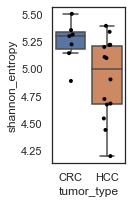

In [11]:
alpha_diversity('blood_HCC_v_CRC', rarefaction=250, save_fig=False, save_rare=False)

Mann Whiteny U rank test: p-value =0.11506967022170822


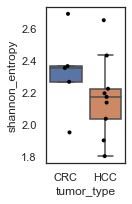

In [26]:
#(supplemental figure)
alpha_diversity('adj_HCC_v_CRC', rarefaction=60, save_fig=False, save_rare=False)

Mann Whiteny U rank test: p-value =0.4805413319725864


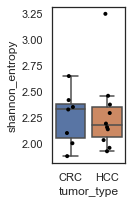

In [73]:
#(supplemental figure)
alpha_diversity('tumor_HCC_v_CRC', rarefaction=60, save_fig=False, save_rare=False)

##### Show exact plot & p-value used in paper

Importing prior table _fig
Mann Whiteny U rank test: p-value =0.04661443132909242


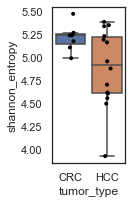

In [12]:
alpha_diversity('blood_HCC_v_CRC', rarefaction=250, import_prior='_fig') #save_fig=True, save_rare=True)

Importing prior table _fig
Mann Whiteny U rank test: p-value =0.2524925375469229


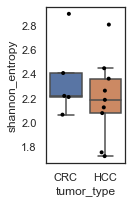

In [56]:
alpha_diversity('adj_HCC_v_CRC', rarefaction=60, import_prior='_fig')

Importing prior table _fig
Mann Whiteny U rank test: p-value =0.33027460260083646


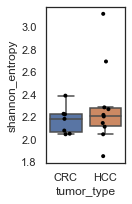

In [94]:
alpha_diversity('tumor_HCC_v_CRC', rarefaction=60, import_prior='_fig')

### Beta Diversity: RPCA

#### Permanova Avg. of Rare Results

##### Reproduce Similar Table with Random Rarefy

###### Blood HCC v CRC

In [13]:
df_rs210_rpca_rare_genome = call_beta('blood_HCC_v_CRC', 'tumor_type', rarefaction=250, numRares=50)


RS210 RPCA Rare Genome


,p-value,pseudo-F,Sample Size
0,0.004,6.770179,21.0
1,0.001,6.588594,21.0
2,0.003,5.514510,21.0
3,0.004,5.909118,21.0
4,0.005,5.797100,21.0
5,0.008,5.199027,21.0
6,0.002,6.510317,21.0
7,0.008,4.905485,21.0
8,0.003,6.637845,21.0
9,0.006,5.792108,21.0


p-value         0.0041
pseudo-F        6.2251
Sample Size    21.0000
dtype: float64


<Figure size 432x288 with 0 Axes>

###### Adj HCC v CRC (supplemental figure)

In [60]:
df_rs210_rpca_rare_genome = call_beta('adj_HCC_v_CRC', 'tumor_type', rarefaction=60, numRares=50)


RS210 RPCA Rare Genome


,p-value,pseudo-F,Sample Size
0,0.027,3.941854,14.0
1,0.353,1.070208,14.0
2,0.386,1.152855,14.0
3,0.807,0.205549,14.0
4,0.935,0.082180,14.0
5,0.998,0.004652,14.0
6,0.566,0.612354,14.0
7,0.634,0.468907,14.0
8,0.887,0.118866,14.0
9,0.147,1.978245,14.0


p-value         0.447440
pseudo-F        1.316098
Sample Size    14.000000
dtype: float64


<Figure size 432x288 with 0 Axes>

###### Tissue HCC v CRC (supplemental figure)

In [95]:
df_rs210_rpca_rare_genome = call_beta('tumor_HCC_v_CRC', 'tumor_type', rarefaction=60, numRares=50)


RS210 RPCA Rare Genome


,p-value,pseudo-F,Sample Size
0,0.370,1.114482,17.0
1,0.003,6.348611,17.0
2,0.470,0.799889,17.0
3,0.051,3.317137,16.0
4,0.693,0.370402,16.0
5,0.296,1.229338,17.0
6,0.002,6.245757,17.0
7,0.167,1.894686,16.0
8,0.122,2.322998,16.0
9,0.017,4.188071,16.0


p-value         0.222500
pseudo-F        2.708786
Sample Size    16.340000
dtype: float64


<Figure size 432x288 with 0 Axes>

##### Show p-value tables used in manuscript

In [14]:
df_rs210_rpca_rare_genome = call_beta('blood_HCC_v_CRC', 'tumor_type', rarefaction=250, open_prior='_fig')

,p-value,pseudo-F,Sample Size
0,0.003,6.373481,21.0
1,0.004,6.778379,21.0
2,0.002,6.962842,21.0
3,0.002,7.202743,21.0
4,0.005,5.752576,21.0
5,0.011,5.066712,21.0
6,0.002,6.547288,21.0
7,0.003,5.002871,21.0
8,0.003,6.837055,21.0
9,0.004,6.177296,21.0


p-value         0.004060
pseudo-F        6.205155
Sample Size    21.000000
dtype: float64


In [61]:
df_rs210_rpca_rare_genome = call_beta('adj_HCC_v_CRC', 'tumor_type', rarefaction=60, open_prior='_fig')

,p-value,pseudo-F,Sample Size
0,0.027,3.941854,14.0
1,0.353,1.070208,14.0
2,0.386,1.152855,14.0
3,0.807,0.205549,14.0
4,0.935,0.082180,14.0
5,0.998,0.004652,14.0
6,0.566,0.612354,14.0
7,0.634,0.468907,14.0
8,0.887,0.118866,14.0
9,0.147,1.978245,14.0


p-value         0.447440
pseudo-F        1.316098
Sample Size    14.000000
dtype: float64


In [96]:
df_rs210_rpca_rare_genome = call_beta('tumor_HCC_v_CRC', 'tumor_type', rarefaction=60, open_prior='_fig')

,p-value,pseudo-F,Sample Size
0,0.370,1.114482,17.0
1,0.003,6.348611,17.0
2,0.470,0.799889,17.0
3,0.051,3.317137,16.0
4,0.693,0.370402,16.0
5,0.296,1.229338,17.0
6,0.002,6.245757,17.0
7,0.167,1.894686,16.0
8,0.122,2.322998,16.0
9,0.017,4.188071,16.0


p-value         0.222500
pseudo-F        2.708786
Sample Size    16.340000
dtype: float64


#### RPCA Plot + P-value of Rare RPCA

##### Reproduce Similar Graph with Random Rarefy

###### Blood HCC vs. CRC

In [18]:
rpca_biplot_emperor, beta_result_o  = rpca_rare('blood_HCC_v_CRC', rarefaction=250, permutations=999)
beta_result_o

Saved PCoAResults % Properties('biplot') to: processed_data/decoide/deicode_biplot_genome_rs210_rare.qza
Saved DistanceMatrix to: processed_data/decoide/deicode_distance_matrix_genome_rs210_rare.qza


<visualization: Visualization uuid: 43e61ea2-91a1-40c6-b9d2-5d0534c84922>

<Figure size 432x288 with 0 Axes>

In [19]:
rpca_biplot_emperor

<visualization: Visualization uuid: d7b9746b-46e3-44a3-ac8a-2d9bc6a63872>

###### Adj HCC vs. CRC

In [67]:
rpca_biplot_emperor, beta_result_o  = rpca_rare('adj_HCC_v_CRC', rarefaction=60)
beta_result_o

Saved PCoAResults % Properties('biplot') to: processed_data/decoide/deicode_biplot_genome_rs210_rare.qza
Saved DistanceMatrix to: processed_data/decoide/deicode_distance_matrix_genome_rs210_rare.qza


<visualization: Visualization uuid: d069fb6c-9ff4-40b3-b78f-b2e4904f9c7e>

<Figure size 432x288 with 0 Axes>

In [68]:
rpca_biplot_emperor

<visualization: Visualization uuid: fbd06287-3b44-4ca9-b721-20bdd92377ec>

###### Tumor HCC vs. CRC

In [99]:
rpca_biplot_emperor, beta_result_o = rpca_rare('tumor_HCC_v_CRC', rarefaction=60)
beta_result_o

Saved PCoAResults % Properties('biplot') to: processed_data/decoide/deicode_biplot_genome_rs210_rare.qza
Saved DistanceMatrix to: processed_data/decoide/deicode_distance_matrix_genome_rs210_rare.qza


<visualization: Visualization uuid: ff7baa1b-aff3-4526-a641-92e44056d209>

<Figure size 432x288 with 0 Axes>

In [100]:
rpca_biplot_emperor

<visualization: Visualization uuid: 4f71edc3-2349-456e-bbc6-153733dacacb>

##### Show exact plot & p-value used in paper

###### Blood HCC vs. CRC

In [20]:
#Note: This uses the same table so should get the same rpca plot but might get slightly different beta results due to permanova
#Note: this _fig just refers to the same _fig rare table not the 'figure' from the permanova
rpca_biplot_emperor, beta_result_o = rpca_rare('blood_HCC_v_CRC', rarefaction=250, import_prior='_fig')
rpca_biplot_emperor

Importing prior table _fig
Saved PCoAResults % Properties('biplot') to: processed_data/decoide/deicode_biplot_genome_rs210_rare.qza
Saved DistanceMatrix to: processed_data/decoide/deicode_distance_matrix_genome_rs210_rare.qza


<visualization: Visualization uuid: 2cebaeb1-c7e7-4675-bf3d-fcf81ef1a7c6>

<Figure size 432x288 with 0 Axes>

In [21]:
#Beta p-value -- Exact one used in paper (you have to do this way because permanova slightly different every time)

beta = Visualization.load('processed_data/RPCA/beta_rare_250_blood_HCC_v_CRC_pese_pangenome_align-RS210_masked_none_scrubbed_p0.25_figure.qzv')

# View the QZV file -- saved from here
beta

<visualization: Visualization uuid: f03d8eb8-947a-4b75-8ef4-1c834ae05250>

###### Adj HCC vs. CRC

In [69]:
#Note: This uses the same table so should get the same rpca plot but might get slightly different beta results due to permanova
#Note: this _fig just refers to the same _fig rare table not the 'figure' from the permanova
rpca_biplot_emperor, beta_result_o = rpca_rare('adj_HCC_v_CRC', rarefaction=60, import_prior='_fig')
rpca_biplot_emperor

Importing prior table _fig
Saved PCoAResults % Properties('biplot') to: processed_data/decoide/deicode_biplot_genome_rs210_rare.qza
Saved DistanceMatrix to: processed_data/decoide/deicode_distance_matrix_genome_rs210_rare.qza


<visualization: Visualization uuid: b5a68c61-a49a-407b-9daa-366d15d0b37c>

<Figure size 432x288 with 0 Axes>

In [71]:
#Beta p-value -- Exact one used in paper
beta = Visualization.load('processed_data/RPCA/beta_rare_60_adj_HCC_v_CRC_pese_pangenome_align-RS210_masked_none_scrubbed_p0.25_figure.qzv')

# View the QZV file -- saved from here
beta

<visualization: Visualization uuid: d069fb6c-9ff4-40b3-b78f-b2e4904f9c7e>

###### Tumor HCC vs. CRC

In [101]:
#Note: This uses the same table so should get the same rpca plot but might get slightly different beta results due to permanova
#Note: this _fig just refers to the same _fig rare table not the 'figure' from the permanova
rpca_biplot_emperor, beta_result_o = rpca_rare('tumor_HCC_v_CRC', rarefaction=60, import_prior='_fig')
rpca_biplot_emperor

Importing prior table _fig
Saved PCoAResults % Properties('biplot') to: processed_data/decoide/deicode_biplot_genome_rs210_rare.qza
Saved DistanceMatrix to: processed_data/decoide/deicode_distance_matrix_genome_rs210_rare.qza


<visualization: Visualization uuid: 725e217c-a178-436c-be59-23f205155a3a>

<Figure size 432x288 with 0 Axes>

In [102]:
#Beta p-value -- Exact one used in paper
beta = Visualization.load('processed_data/RPCA/beta_rare_60_tumor_HCC_v_CRC_pese_pangenome_align-RS210_masked_none_scrubbed_p0.25_figure.qzv')

# View the QZV file -- saved from here
beta

<visualization: Visualization uuid: ff7baa1b-aff3-4526-a641-92e44056d209>

### Abudance Maps

In [2]:
#Pull the top 10 upper/lower GOTUs from birdman , then subset df by them
birdman_df = pd.read_csv('figures/blood_HCC_v_CRC_qiita15336_prep16181_pangenome_rs210_scrubbed_zebraFilter0.1.tsv', sep = '\t')

#Import biom tables in df format
df_rs210_genome = pd.read_csv('processed_data/pandas_df/blood_HCC_v_CRC_qiita15336_prep16181_pangenome_rs210_scrubbed_zebraFilter0.1.tsv' , sep='\t', index_col = 0)

#Subset df by feature
birdman_rs210 = df_rs210_genome.loc[birdman_df['Feature'].to_list()]
#birdman_rs210['GOTU'] = birdman_rs210.index

In [4]:
#Pull the top 10 upper/lower GOTUs from birdman , then subset df by them
birdman_df = pd.read_csv('figures/blood_HCC_v_CRC' + key_var + '.tsv', sep = '\t')

#Import biom tables in df format
df_rs210_genome = pd.read_csv('processed_data/pandas_df/blood_HCC_v_CRC' + key_var + '.tsv' , sep='\t', index_col = 0)

#Subset df by feature
birdman_rs210 = df_rs210_genome.loc[birdman_df['Feature'].to_list()]
#birdman_rs210['GOTU'] = birdman_rs210.index

In [5]:
# Reset index and melt the DataFrame
melt_birdman = pd.melt(birdman_rs210.reset_index(), id_vars='index', var_name='sample_name', value_name='count')

#Add in other helpful columns from birdman run
sample_dict_tax = dict(zip(birdman_df['Feature'], birdman_df['gOTU_Taxonomy']))
sample_dict_mean = dict(zip(birdman_df['Feature'], birdman_df['tumor_type[T.HCC]_mean']))
melt_birdman['gOTU_Taxonomy'] = melt_birdman['index'].map(sample_dict_tax)
melt_birdman['tumor_type[T.HCC]_mean'] = melt_birdman['index'].map(sample_dict_mean)
melt_birdman['mean_taxonomy'] = melt_birdman['tumor_type[T.HCC]_mean'].astype(int).astype(str) + '_' + melt_birdman['gOTU_Taxonomy']
melt_birdman['tumor_type_mean'] = np.where(melt_birdman['tumor_type[T.HCC]_mean'] < 0, 'CRC', 'HCC')
melt_birdman['mean_taxonomy_def'] = melt_birdman['tumor_type_mean'] + ' : ' + melt_birdman['gOTU_Taxonomy']

# Create a heatmap
#plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
birdman_map = melt_birdman.pivot(index="mean_taxonomy_def", columns="sample_name", values="count")

#Re-order to match birdman output
birdman_map.reset_index(inplace=True)
order = melt_birdman['mean_taxonomy_def'].unique()
birdman_map = birdman_map.set_index('mean_taxonomy_def').loc[order]

#### Heatmap

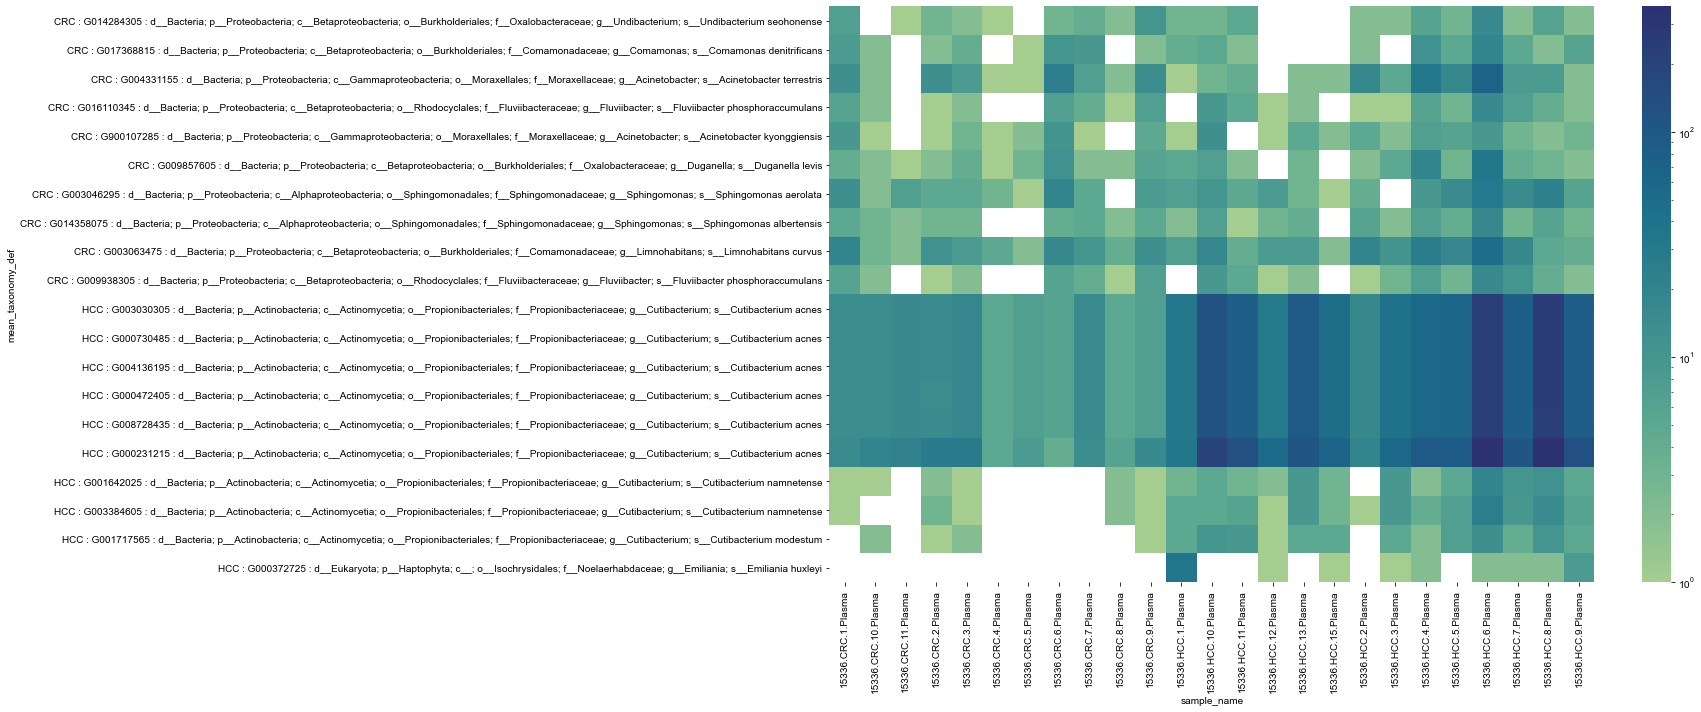

In [8]:
fig, ax = plt.subplots(figsize=(25, 10))

sns.heatmap(birdman_map, norm=LogNorm(), cmap="crest") #annot=True, vmin=0, vmax=20)

# Display the heatmap
plt.tight_layout()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['svg.fonttype'] = 'none'  # render SVG text as text, not curves
plt.savefig('figures/birdman_abundance_heatmap.svg')
plt.show()

#### Cluster Map

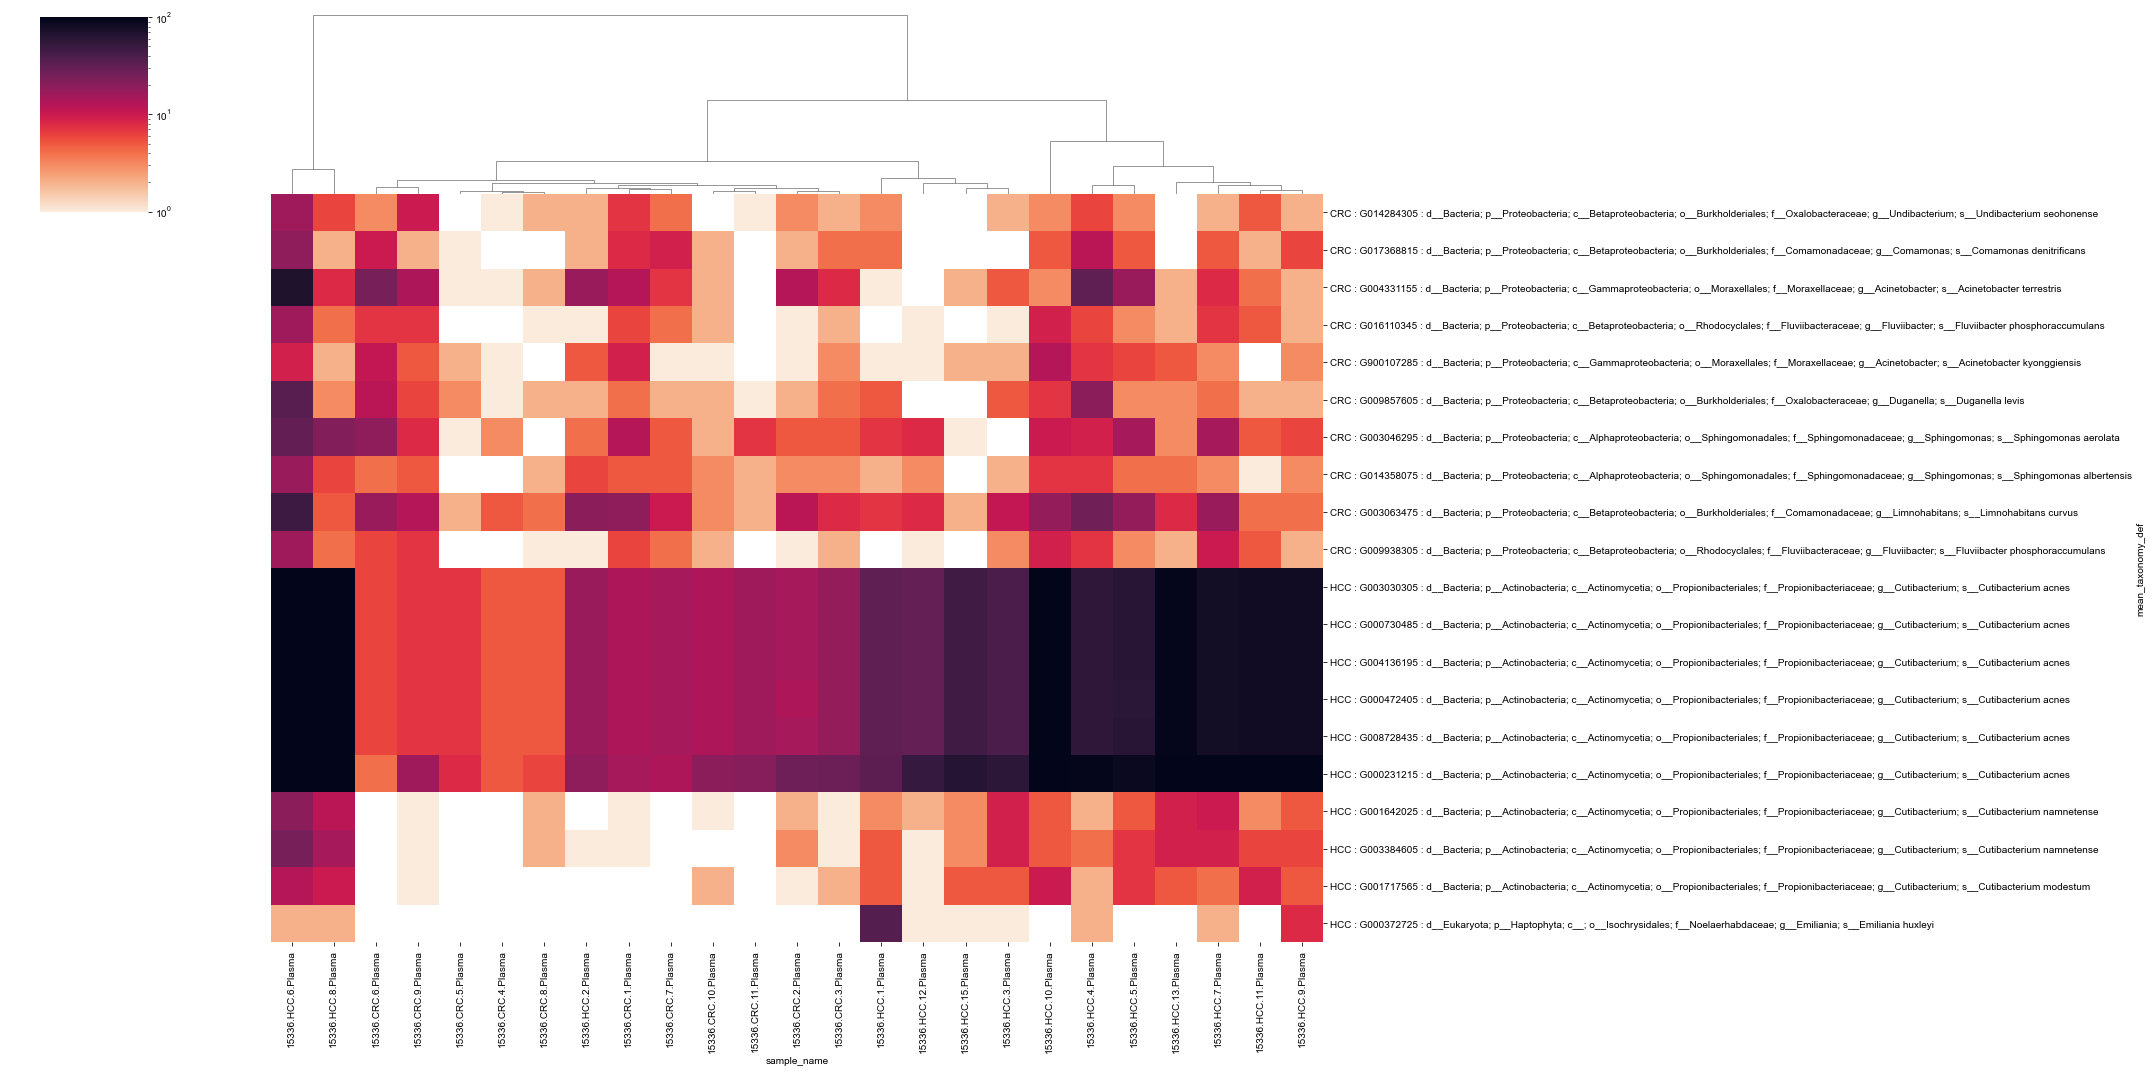

In [9]:
# Create a cluster map and set colorbar normalization
sns.clustermap(birdman_map, norm=LogNorm(vmin=1, vmax=100), cmap="rocket_r",
               row_cluster=False, col_cluster=True, 
               #norm=SymLogNorm(linthresh=10,vmin=0, vmax=birdman_map.max().max()),
               figsize=(30, 15), method='complete') #complete, average, ward

#plt.tight_layout()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['svg.fonttype'] = 'none'  # render SVG text as text, not curves
plt.savefig('figures/birdman_abundance_clustermap.svg')
plt.show()

#### Average Columns

/Users/cguccion/miniconda3/envs/comad/lib/python3.8/site-packages/seaborn/matrix.py:1205: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


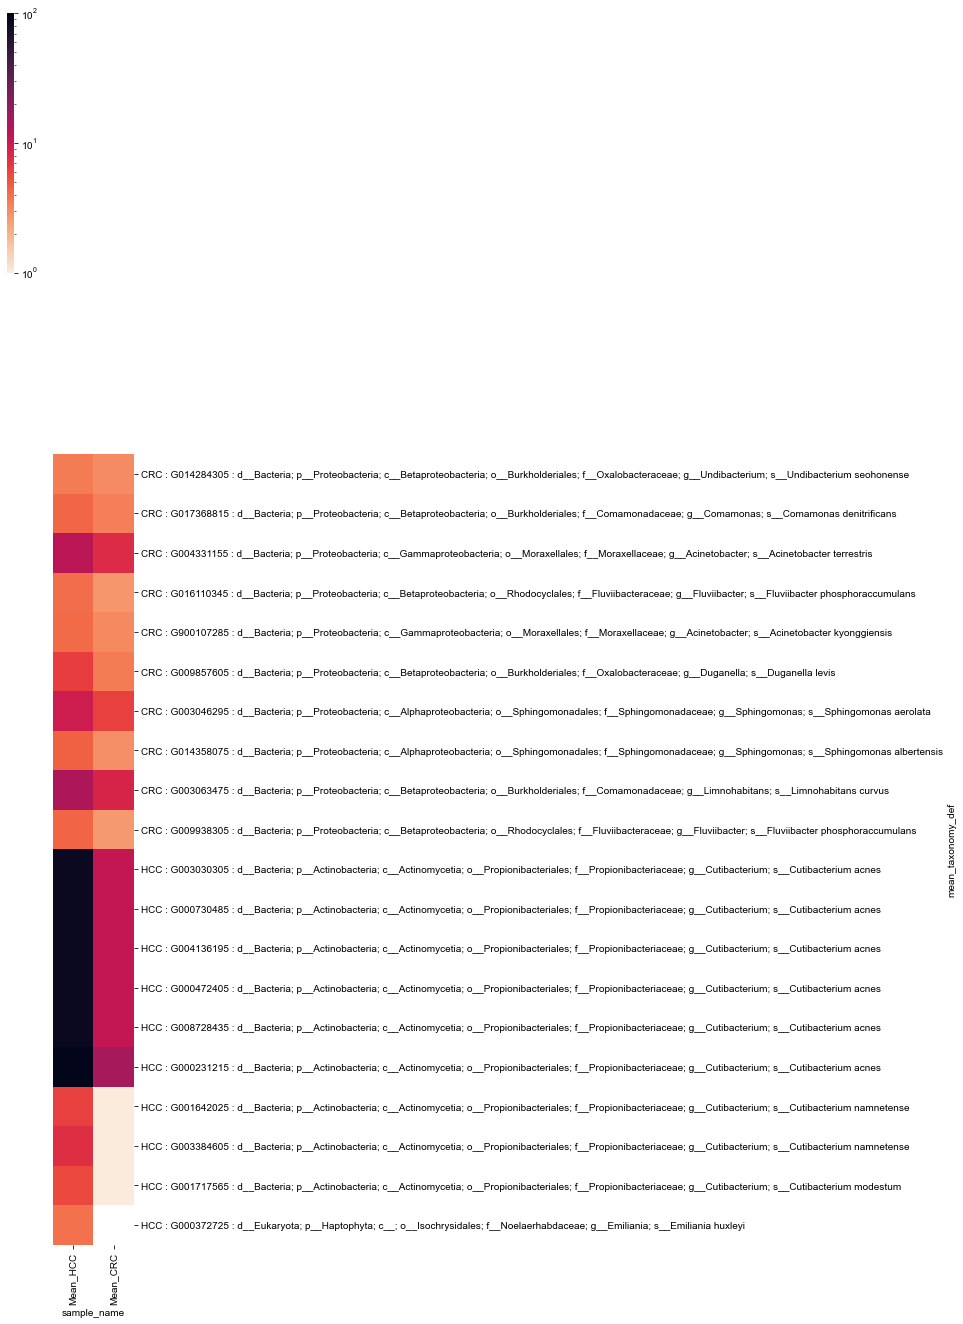

In [10]:
birdman_col = birdman_map.copy()

# Select columns containing 'HCC' or 'CRC'
hcc_columns = birdman_col.filter(like='HCC').columns
crc_columns = birdman_col.filter(like='CRC').columns

# Calculate mean along the selected columns for each row
birdman_col['Mean_HCC'] = birdman_col[hcc_columns].mean(axis=1)
birdman_col['Mean_CRC'] = birdman_col[crc_columns].mean(axis=1)

# Drop unnecessary columns
birdman_col = birdman_col.loc[:, birdman_col.columns.get_level_values(0).isin(['mean_taxonomy_def', 'Mean_HCC', 'Mean_CRC'])]

sns.clustermap(birdman_col, norm=LogNorm(vmin=1, vmax=100), cmap="rocket_r",
               row_cluster=False, col_cluster=False, 
               figsize=(2, 20))

#plt.tight_layout()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['svg.fonttype'] = 'none'  # render SVG text as text, not curves
plt.savefig('figures/birdman_abundance_mean.svg')
plt.show()